# Classification of cloud organization types from satellite imagery

**Introduction**

Cloud organization is a hot topic in atmospheric science research. Clouds represent an integral part of the earth system, but they are also notoriously difficult to model and understand. One reason for this difficulty comes from the fact that for a given cloud fraction clouds can assume very different structures. 

A fundamental problem in understanding cloud organization comes from the difficulty in objectively measuring the degree of organization. Heuristic metrics often only partly agree with human intuition. For this reason six cloud experts hand labelled around 900 satellite images just East of Barbados.

Our task here is to find out whether an image classification neural network could automate this task for new images.

**The dataset**

The dataset contains around 900 images. There were six labels to chose from for the experts. On most of the cases the experts did not agree, so that rather than definite labels, we instead have probabilities.

The images were downloaded from NASA Worldview and preprocessed by a student at the Max-Plank-Institute for Meteorology in Hamburg. Thanks a lot for that! The raw image size is 1144 by 1140 pixels. 

We will explore the different organization types below.

**The challenge**

In terms of image classification networks, the present dataset poses three big challenges:
1. 900 images is not a lot
2. Probabilistic labels add uncertainty
3. The classes are unbalanced, i.e. certain labels are much more common than others


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from utils import *

Using TensorFlow backend.


In [3]:
IMG_DIR = '/home/paperspace/data/cloud_images/'
#IMG_DIR = '/beegfs/DATA/pritchard/srasp/MPI_Aqua/'
raw_info = pd.read_csv('./mpi_numbers/labels.csv')
info = pd.read_csv('./mpi_numbers/oversampled_labels.csv')

In [4]:
classes = list(info.columns[1:]); classes

['0 - no fit',
 '1 - flower',
 '2 - fishbone',
 '3 - cold pool',
 '4 - shallow',
 '5 - banded']

## Explore the data

Let's start by looking at some images and statistics.

In [5]:
unanimous_fns = [IMG_DIR + info.iloc[get_unianimous_idxs(info, c, return_max=True)[0]]['fn'] 
                 for c in info.columns[1:]]

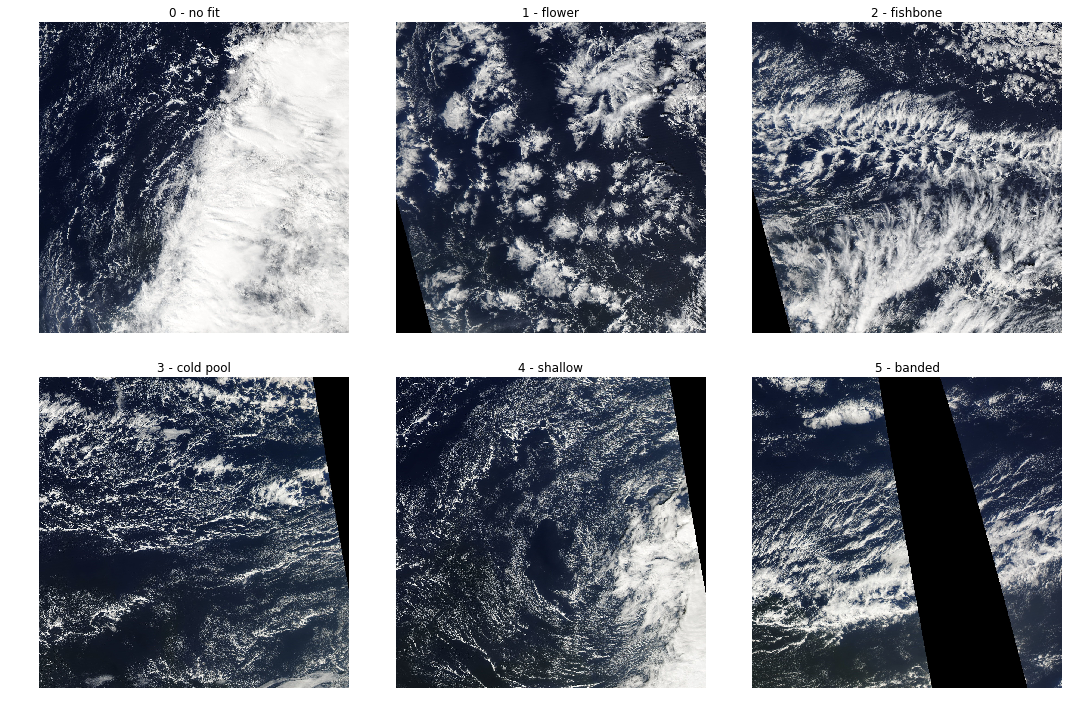

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(list(axes.reshape(-1))):
    ax.imshow(Image.open(unanimous_fns[i]))
    ax.set_title(classes[i])
    plt.sca(ax); plt.axis('off')
plt.tight_layout()

Here are the categories described courtesy of Ann Kristin Naumann from the Max-Planck-Institute for Meteorology.

- "0 - no fit": Either a blend of categories, or no obvious fit to any of the categories
- "1 - flower": Large-scale flower like patterns, with dark cloud free regions separating flowers
- "2 - fishbone": Like flowers but structures dominated by cold-pool networks, perhaps elongated.
- "3 - cold pool": regular network of small scale cold pools, and sometimes granular shallow clouds
- "4 - shallow": maybe stratiform clouds or regular bands, but evidently thin shallow clouds
- "5 - banded": arge-scale bands, perhaps as part of a larger scale frontal system

Next let's look at how frequently these classes appear in our dataset.

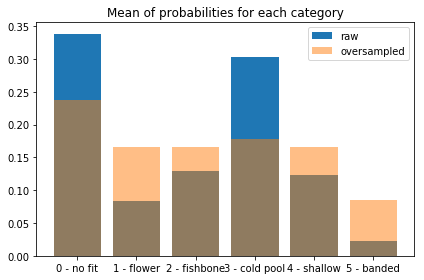

In [7]:
plot_bar([np.mean(np.array(raw_info.iloc[:, 1:]), axis=0),
          np.mean(np.array(info.iloc[:, 1:]), axis=0)],
         'Mean of probabilities for each category', classes, ['raw', 'oversampled'])

The blue bars represent the average probabilities from the raw dataset. Here we can see a strong class imbalance: "No fit" and "Cold pool" are much more common than the others, especially "Banded". This would encourage the model to mostly predict these two classes, which wouldn't be a very descriptive model. 

To alleviate this issue, I created an oversampled dataset which contains some of the rarer images multiple times. I did this both for the training and validation set, which we will have to take into account when analyzing the results below.

In [8]:
len(raw_info), len(info)

(870, 2120)

## Prepare the data for the neural net

Now let's look at the image preprocessing we do for the neural net. Specifically, a technique called data augmentation.

To start with we will resize the images to 512x512 pixels, which is around halve of the original size. 

In [9]:
balanced_img_arrs = np.load(IMG_DIR + 'balanced_img_arrs_512.npy'); balanced_img_arrs.shape

(2120, 512, 512, 3)

One big problem when fitting neural networks with tens of thousands of parameters is overfitting. This term describes what happens when the network is getting better and better on the data it is trained on, but does not generalize to unseen data. For this reason it is crucial to have a training set and a separate validation set to evaluate the performance of the model.

In [10]:
with open('./val_idxs.pkl', 'rb') as f:
    unbalanced_val_idxs, balanced_val_idxs = pickle.load(f)

In [11]:
# Split the input images into a train and validation set
X_train = balanced_img_arrs[revert_idxs(balanced_val_idxs, balanced_img_arrs.shape[0])]
X_valid = balanced_img_arrs[balanced_val_idxs]

In [12]:
# Do the same with the labels
y_train = np.array(info.iloc[:, 1:])[revert_idxs(balanced_val_idxs, balanced_img_arrs.shape[0])]
y_valid = np.array(info.iloc[:, 1:])[balanced_val_idxs]

One technique to alleviate the overfitting problem is called data augmentation. Here, we randomly change the images everytime we show them to the network to train. The involves rotating and flipping the image as we can see here. 

In [35]:
aug_ims = [next(ImageDataGenerator(
        rotation_range=10, horizontal_flip=True, vertical_flip=True
    ).flow(np.expand_dims(X_train[1], 0)))[0] for i in range(4)]

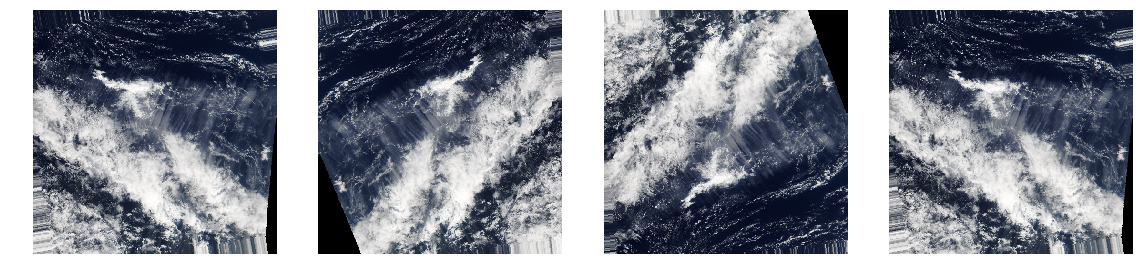

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
for i, ax in enumerate(axes):
    ax.imshow(deproc(aug_ims[i])); plt.sca(ax); plt.axis('off')
plt.tight_layout()

## Building and training the model

Now we come to the heart of the neural net.

Neural nets consist of several interconnected layers. Each layer consists of a certain number of nodes. How strongly each node from one layer is connected to a node in the next layer is determined by a weight matrix. Additionally, every node also has a bias associated with it. 

Training the neural net means figuring out the weights and biases that give the lowest loss (in our case the log of the probability difference between the predictions and training labels). 

For image networks in particular, instead of fully connected layers, where each node in one layer is connected with each node in the next layer, we use convolutional layer. Here we learn the weights of a convolutional filter that moves over the channels of the image. Successive convolutional filters will decrease the image size, but increase the channels.

We are using Keras, a high-level neural network library sitting on top of Google's TensorFlow.

In [37]:
def create_cnn(dr=0.):
    model = Sequential([
        Convolution2D(128,3, strides=1, activation='relu', input_shape=(None, None, 3), padding='same'),
        MaxPool2D(strides=2),
        Convolution2D(128,3, strides=1, activation='relu',padding='same'),
        MaxPool2D(strides=2),
        Convolution2D(128,3, strides=1, activation='relu',padding='same'),
        MaxPool2D(strides=2),
        Convolution2D(6, 3, strides=1),
        Dropout(dr),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ])
    return model

In [38]:
model = create_cnn(0.)

As a loss function for our neural net we are using the Kullback-Leibler divergence, which measures the discrepency between two probability distributions.

In [39]:
model.compile(Adam(1e-3), 'kld', metrics=['mae'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 128)   3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 6)     6918      
__________

Our final model has around 300k parameters. The fitting process for our small dataset takes under one hour. We will now load a model which I already trained.

In [13]:
model = keras.models.load_model('fully_conv_nodr_512_2.h5')

## Evaluating the model predictions

Now let's check out how well our model does on the validation dataset. First, let's get some statistics before looking at examples.

In [49]:
model.evaluate(X_valid, y_valid)[1]

431/431 [==============================] - 6s 14ms/step


0.11225997099951082

In [48]:
p = model.predict(X_valid)
max_acc(y_valid, p)

0.74013921113689096

The first score 0.11 tells us that for each category we are on average 11% wrong. In other words, out of a maximum total error of 200%, the model gets 66% wrong. The second score 0.74 tells us how often the model had the same top prediction as the experts. 

Next up let's look at some examples.

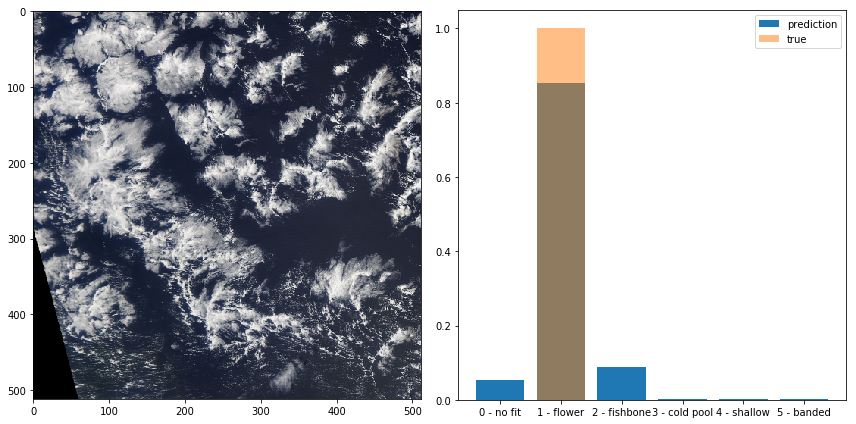

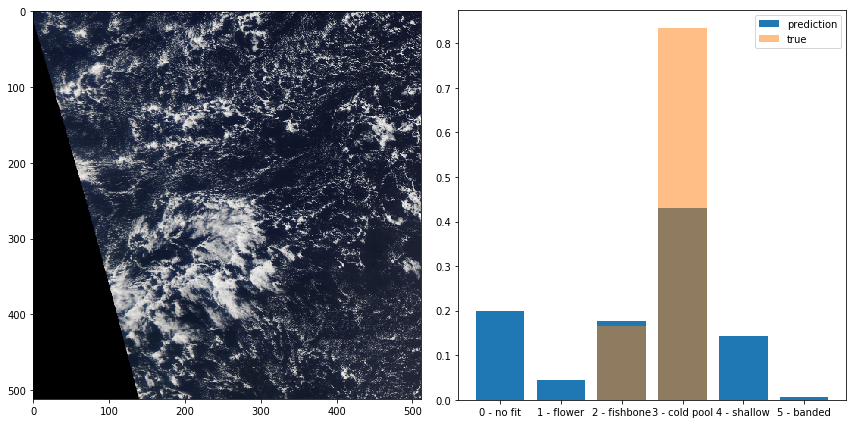

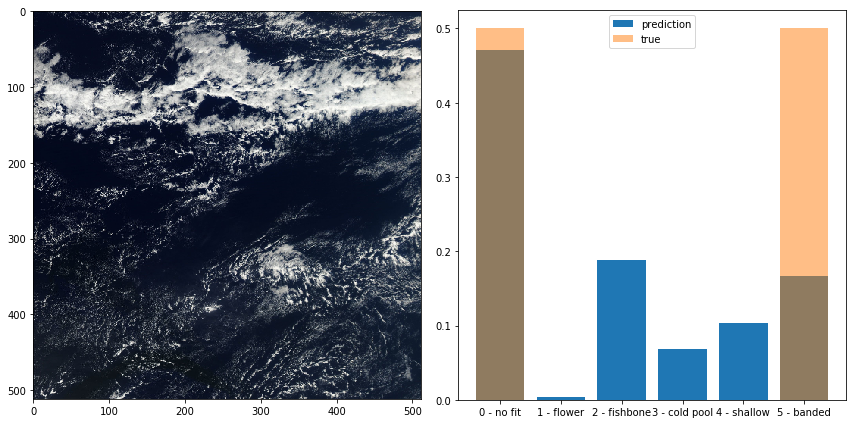

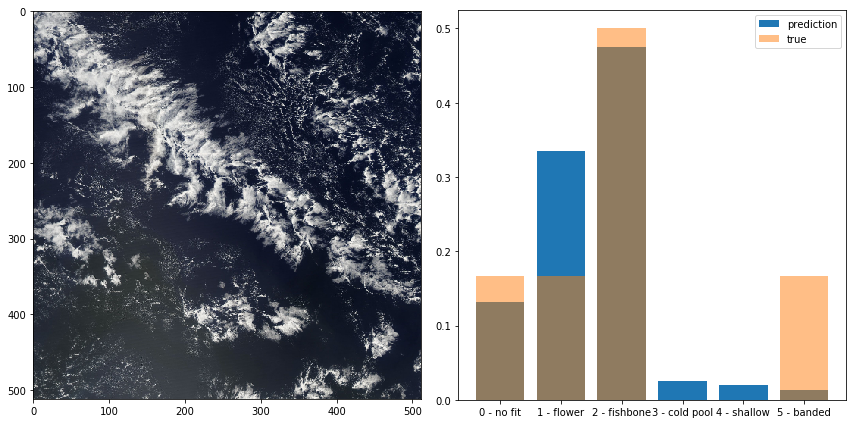

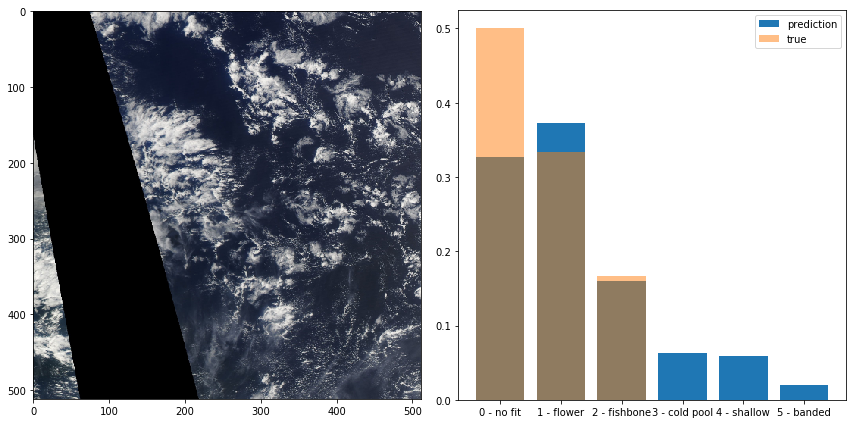

In [63]:
for i in list(np.random.randint(0, X_valid.shape[0], 5)):
    show_pred_keras(X_valid, y_valid, p, i, classes)

So how good is the model. I would say that it definitely has some intuition about the images it is looking at. It never is completely wrong, but of course it could do better sometimes.

## Looking into the network's brain - class activation maps

Finally, we will try to understand why the neural net decided to make the predictions it made. There is a misconception that neural nets are black boxes, which magically make dicisions without reason. But this is only partly true. There are several techniques to look at the inner workings of the neural net. 

We will use class activation maps to create a heatmap showing us which pixels were important to make the predictions. 

In [14]:
def plot_cam_keras(model, idx, X, y, label=None, return_cam=False):
    sz=X.shape[1]
    l = model.layers
    conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])
    inp = X[idx][None]; true = y[idx]
    conv = conv_fn([inp, 0])[0][0]
    if label is None:
        y = model.predict(inp)[0]
    else:
        y = np.zeros(6)
        y[label] = 1
    cam = np.dot(conv, y)
    cam -= cam.min(); cam /= cam.max()
    if return_cam:
        return cam
    else:
        print("['0 - no fit', '1 - flower', '2 - fishbone', '3 - cold pool', '4 - shallow', '5 - banded']")
        print('True:', true)
        print('Pred:', y)
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(deproc(inp[0]))
        ax.imshow(resize(cam, (sz, sz)), cmap='hot', alpha=0.5, vmin=0.2, vmax=1.)

['0 - no fit', '1 - flower', '2 - fishbone', '3 - cold pool', '4 - shallow', '5 - banded']
True: [ 0.16666667  0.16666667  0.5         0.          0.          0.16666667]
Pred: [ 0.13180961  0.33471113  0.47464946  0.02562775  0.01991834  0.01328364]


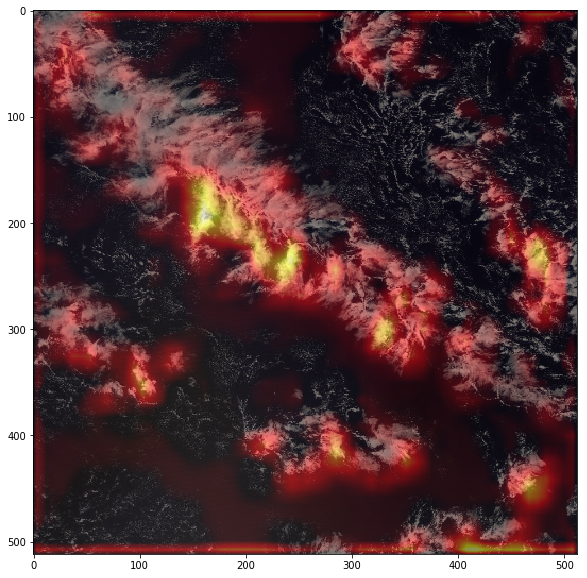

In [24]:
plot_cam_keras(model, 15, X_valid, y_valid)

Here we can see for example which regions the network focused on to make the fishbone/flowers prediction.

['0 - no fit', '1 - flower', '2 - fishbone', '3 - cold pool', '4 - shallow', '5 - banded']
True: [ 0.33333334  0.          0.          0.          0.66666669  0.        ]
Pred: [ 0.10478041  0.05003337  0.10396762  0.08361081  0.63369614  0.02391157]


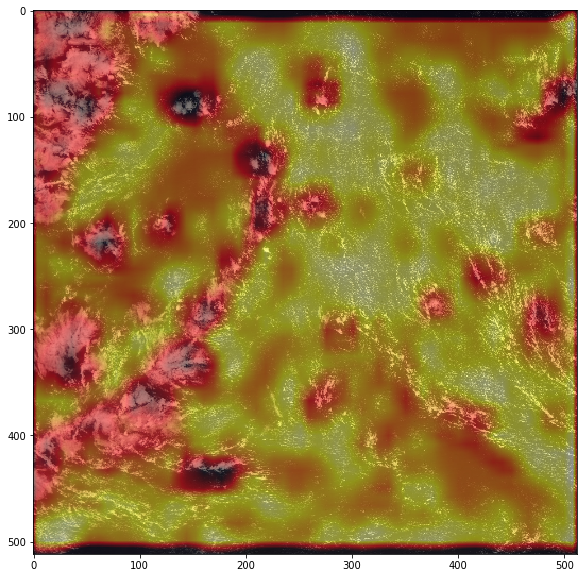

In [30]:
plot_cam_keras(model, 20, X_valid, y_valid)

['0 - no fit', '1 - flower', '2 - fishbone', '3 - cold pool', '4 - shallow', '5 - banded']
True: [ 0.          0.          0.          0.33333334  0.66666669  0.        ]
Pred: [ 0.18788682  0.0110997   0.03964938  0.25931045  0.49323496  0.00881869]


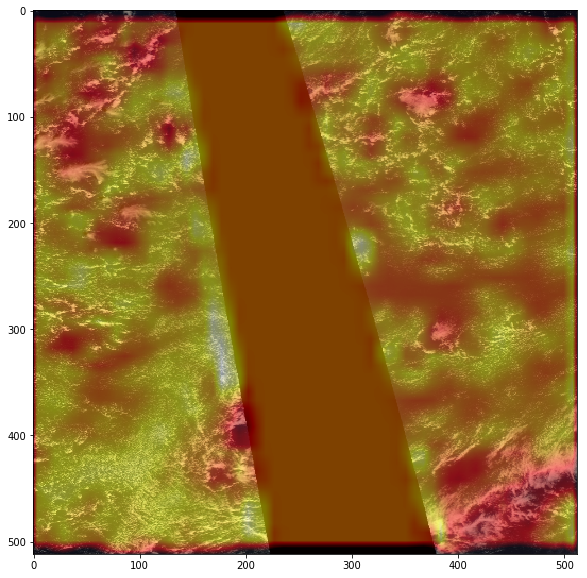

In [95]:
plot_cam_keras(model, 85, X_valid, y_valid)

['0 - no fit', '1 - flower', '2 - fishbone', '3 - cold pool', '4 - shallow', '5 - banded']
True: [ 0.          0.          0.          0.33333334  0.66666669  0.        ]
Pred: [ 0.  0.  0.  1.  0.  0.]


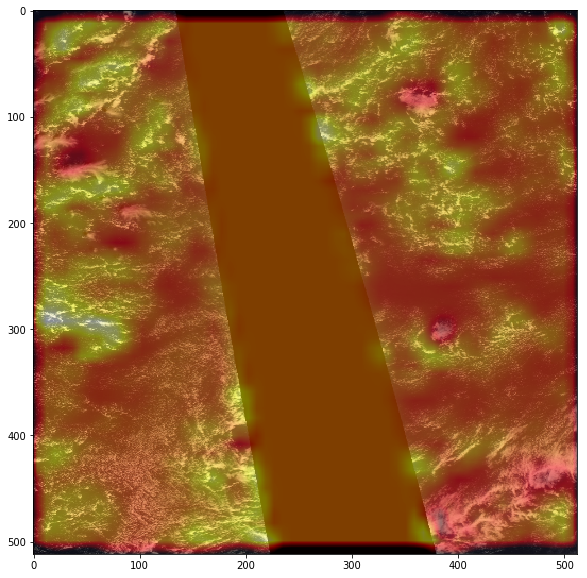

In [96]:
plot_cam_keras(model, 85, X_valid, y_valid, 3)

['0 - no fit', '1 - flower', '2 - fishbone', '3 - cold pool', '4 - shallow', '5 - banded']
True: [ 0.          0.          0.          0.33333334  0.66666669  0.        ]
Pred: [ 0.  0.  0.  0.  1.  0.]


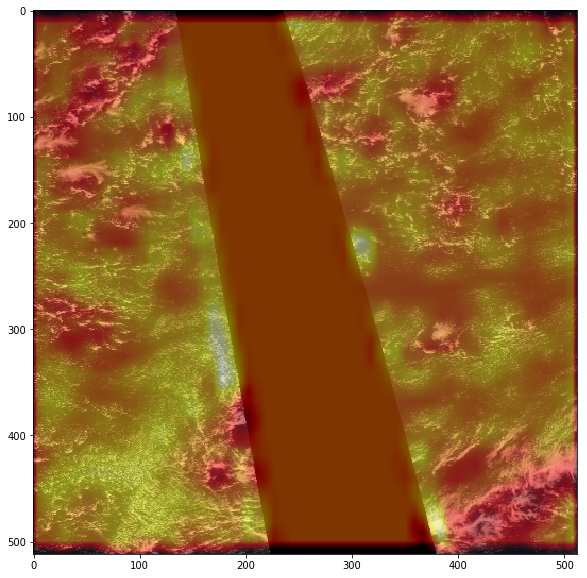

In [97]:
plot_cam_keras(model, 85, X_valid, y_valid, 4)

## Final words

We have seen that we can create a model that provides reasonable predictions and even seems to understand a little bit about the data. The biggest problem we had here was the limited amount of data. I would estimate that with a few thousand images the results would be quite a bit better. 

While the amount of data was certainly a limitation here, deep learning does not require "big data". Even with reasonably sized datasets of a few thousand images, it is possible to build a useful model.

Finally, let me thank Ann Kristin and Julia and the student who downloaded and processed the images. 

In [12]:
#End